In [4]:
import os 
import sys 

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [8]:
# ======== UCLA LDCT ========
# IN_FEATURE_PATH = '/workspace/home/tengyuezhang/sybil_cect/results/ucla_ldct/ucla_ldct_20_raw_features.csv'
# dataset = 'UCLA LDCTs' # title of the t-SNE plot 
# ======== UCLA CECT ========
# IN_FEATURE_PATH = '/workspace/home/tengyuezhang/sybil_cect/results/ucla_cect/ucla_cect_98_raw_features.csv'
# dataset = 'UCLA CECTs'
# ======== NLST LDCT ========
# IN_FEATURE_PATH = '/workspace/home/tengyuezhang/sybil_cect/results/nlst_baseline/nlst_raw_features.csv'
# dataset = 'NLST LDCTs'
# ======== LUNGx CECT ========
IN_FEATURE_PATH = '/workspace/home/tengyuezhang/sybil_cect/results/lungx/lungx_features.csv'
dataset = 'LUNGx CECTs'

In [11]:
df = pd.read_csv(IN_FEATURE_PATH)
if dataset == 'UCLA LDCTs':
    df['lung_cancer'] = df['diagnosis']
elif dataset == 'LUNGx CECTs':
    df['lung_cancer'] = df['Diagnosis']

In [12]:
feature_columns = [col for col in df.columns if col.startswith("feature_")]
features = df[feature_columns].values

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(features)

df["tsne_1"] = tsne_results[:, 0]
df["tsne_2"] = tsne_results[:, 1]

/home/tengyuezhang/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tengyuezhang/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
# generate year-1 label for NLST 
def calculate_y_seq(event, time_to_event, max_followup=6):
    """
    Calculate the binary outcome sequence based on the event and time_to_event.
    Returns 
        y_seq: a numpy array of length max_followup, where y_seq[i] is 1 if the case was censored at year i, and 0 otherwise.
    """
    y_seq = np.zeros(max_followup)

    if event == 1:
        # Convert time_to_event to integer index (year)
        event_year = int(time_to_event)
        
        # Ensure the event year does not exceed the follow-up period
        event_year = min(event_year, max_followup)
        
        # Set all y_i from the event year onward to 1
        y_seq[event_year:] = 1
    
    return y_seq

if dataset == 'NLST LDCTs': 
    for i in range(6): # create columns 
        df[f'y_{i}'] = np.nan 
    for index, row in df.iterrows():
        event = row['event']
        time_to_event = row['years_to_event']
        y_seq = calculate_y_seq(event, time_to_event, max_followup=6)
        for i in range(6):
            df.at[index, f'y_{i}'] = y_seq[i]
    df['lung_cancer'] = df['y_0']

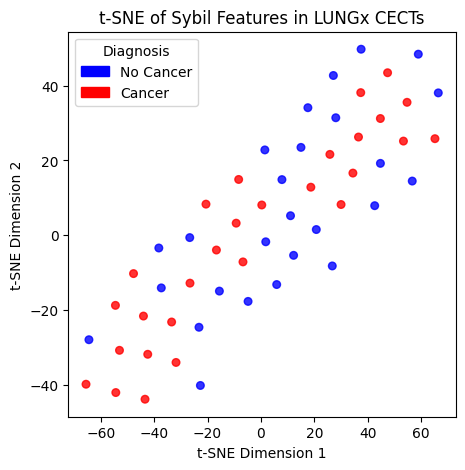

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

binary_cmap = ListedColormap(["blue", "red"])  # Green for 0 (no cancer), red for 1 (cancer)

# Plot t-SNE
plt.figure(figsize=(5,5))
scatter = plt.scatter(
    df["tsne_1"], 
    df["tsne_2"], 
    c=df["lung_cancer"].values, 
    cmap=binary_cmap, 
    s=30, 
    alpha=0.8,
)

legend_labels = {
    0: "No Cancer", 
    1: "Cancer"
}
handles = [
    mpatches.Patch(color="blue", label=legend_labels[0]),
    mpatches.Patch(color="red", label=legend_labels[1])
]
plt.legend(handles=handles, title="Diagnosis", loc="upper left")

plt.title(f"t-SNE of Sybil Features in {dataset}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
